<a href="https://colab.research.google.com/github/sli032/BIO-PHY4100/blob/main/DNA:RNA_polyer_modeling_HOOMD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installation & Render code

Run the code only once, then click the arrow by "Utility code" to hide them.

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [2]:
!conda install -c conda-forge hoomd gsd

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [3]:
!conda install -c conda-forge fresnel freud

Channels:
 - conda-forge
Platform: linux-64
Solving environment: \ | / - done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.3.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.



In [4]:
import math
import warnings

import fresnel
import freud
import gsd.hoomd
import hoomd
import IPython
import matplotlib
import numpy
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=400, h=400)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04

    if (hasattr(snapshot, 'log')
            and 'particles/md/pair/LJ/energies' in snapshot.log):
        energies = snapshot.log['particles/md/pair/LJ/energies']
        mapper = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=numpy.min(energies),
                                             vmax=numpy.max(energies),
                                             clip=True),
            cmap=matplotlib.cm.get_cmap(name='viridis'))
        geometry.color[:] = fresnel.color.linear(mapper.to_rgba(energies))
        geometry.material.primitive_color_mix = 1

    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=20)._repr_png_())


warnings.filterwarnings('ignore', module='hoomd')

# Introducing molecular dynamics

This hands-on workshop introduces the basic concepts of HOOMD-blue and will teach you how to run a molecular dynamics simulation. For more details, information that may be helpful when completing the exercises, see the [HOOMD-blue documentation](https://hoomd-blue.readthedocs.io/).

**Google Colab users:** Click the "Copy to Drive" button in the toolbar to save this notebook and any edits that you make to your Google Drive.

## Create the simulation and initial state


In [5]:
cpu = hoomd.device.CPU()
sim = hoomd.Simulation(device=cpu, seed=2)

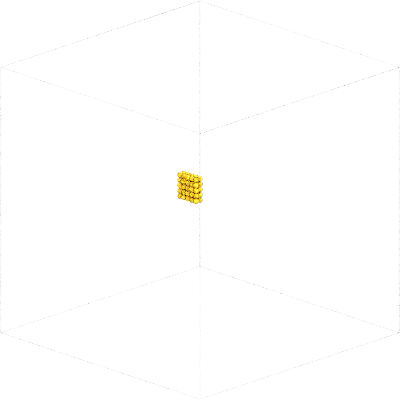

In [8]:
snapshot = hoomd.Snapshot()
# box, positions = freud.data.UnitCell.bcc().generate_system(num_replicas=4,
                                                          #  scale=1.5)

a = 1
chainN = 50

particles = [[0.,0.,0.]]
step = numpy.array([-a, 0., 0.])
turnstep = numpy.array([0., a, 0.])
upstep = numpy.array([0., 0., a])
for i in range(1, chainN):
  if i % 5 == 0:
    step = -step
    if (i/5) % 5 == 0:
      particles.append(particles[-1] + upstep)
      turnstep = -turnstep
    else:
      particles.append(particles[-1] + turnstep)
  else:
    particles.append(particles[-1] + step)
bonds = [[i, i+1] for i in range(chainN - 1)]
angles = [[i, i+1, i+2] for i in range(chainN - 2)]


snapshot.particles.N = len(particles)
snapshot.particles.position[:] = particles
snapshot.particles.types = ['A']

snapshot.bonds.N = len(bonds)
snapshot.bonds.group[:] = bonds
snapshot.bonds.types = ['bond']


snapshot.angles.N = len(angles)
snapshot.angles.group[:] = angles
snapshot.angles.types = ['bend']

snapshot.configuration.box = [50, 50, 50, 0, 0, 0]
render(snapshot)

# bodyid = -1

# diameters = [size] * n
# types = [ptypename] * n
# bodyids = [bodyid] * n
# moment_inertias = [moment_inertia] * n
# masses = [mass] * n


In [9]:
sim.create_state_from_snapshot(snapshot)

## Molecular dynamics classes

The MD integrator numerically integrates the equations of motion:

In [10]:
integrator = hoomd.md.Integrator(dt=0.005)

You need a neighbor list to compte pairwise interactions:

In [11]:
cell = hoomd.md.nlist.Cell(buffer=0.4)

In [12]:
harmonic = hoomd.md.bond.Harmonic()
harmonic.params['bond'] = dict(k=100.0, r0=1.2)
integrator.forces.append(harmonic)
# lj = hoomd.md.pair.LJ(nlist=cell)
# lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)

The integration **method** sets the specific equations of motion that apply to a subset of particles:

In [13]:
brownian = hoomd.md.methods.Brownian(filter=hoomd.filter.All(), kT=1.5)
integrator.methods.append(brownian)
sim.operations += integrator

## Running a molecular dynamics simulation

In [43]:
array_logger = hoomd.logging.Logger()
array_logger.add(harmonic, quantities=["energies", "forces"])
gsd_writer = hoomd.write.GSD(
    filename="trajectory.gsd",
    trigger=hoomd.trigger.Periodic(100),
    logger=array_logger,
    mode="wb",
    filter=hoomd.filter.All(),
)
sim.operations += gsd_writer

In [44]:
sim.run(10000)

In [45]:
print(sim.state.get_snapshot().particles.position[0:5, :])

[[-3.65012827  3.41169925 -2.08412431]
 [-3.42506878  2.37493461 -2.72981866]
 [-3.53935178  2.14272458 -1.58299669]
 [-3.58745346  3.07542081 -0.99999971]
 [-2.42769241  3.86235592 -1.18240954]]


## Logging energy and dump trajectory

HOOMD-blue can log array quantities, such as the per particle energies.
Include the logged quantities in a GSD trajectory:

In [47]:
with gsd.hoomd.open('trajectory.gsd', 'r') as trajectory:
    for frame in trajectory:
        energies = frame.log['particles/md/pair/LJ/energies']
        print(energies.mean(), energies.std())

In [48]:
with gsd.hoomd.open('trajectory.gsd', 'r') as trajectory:
    image = render(trajectory[-1])
image

IndexError: 

## Define Rg and Log Rg

Use a Logger to monitor how properties of the simulation vary during the run:

In [36]:
logger = hoomd.logging.Logger(categories=['scalar'])
logger += sim
logger.add(thermo, quantities=['potential_energy'])

Use the `Table` writer to display the logged values:

In [37]:
table = hoomd.write.Table(trigger=hoomd.trigger.Periodic(100),
                          logger=logger,
                          max_header_len=5,
                          max_precision=2)
sim.operations += table

Remove the table writer:

In [38]:
sim.operations -= table